Hurst exponent , kauffman efficiency and ADF test

In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
import backtrader as bt
import matplotlib.pyplot as plt
import seaborn as sn

In [2]:
from curl_cffi import requests

session = requests.Session(impersonate="chrome")
ticker = yf.Ticker('AMT', session=session)
risk_free = yf.Ticker('^GSPC', session=session)

# Set time horizon using the `period` or `start`/`end` arguments
amt_data = ticker.history(period="1y")  # Last 1 year
sp500_data = risk_free.history(start="2023-01-01", end="2024-01-01")  # Custom range
return_df= amt_data[['Close']].reset_index()
return_df.columns = ['Date', 'Close']
riskfree_df = sp500_data[['Close']].reset_index()
riskfree_df.columns = ['Date', 'Close']

return_df['Date'] = pd.to_datetime(return_df['Date'])
return_df['Date'] = return_df['Date'].dt.strftime('%Y-%m-%d')
return_df.head()
riskfree_df['Date'] = pd.to_datetime(riskfree_df['Date'])
riskfree_df['Date'] = riskfree_df['Date'].dt.strftime('%Y-%m-%d')

return_df.head()
riskfree_df.head()

,Date,Close
0,2023-01-03,3824.139893
1,2023-01-04,3852.969971
2,2023-01-05,3808.100098
3,2023-01-06,3895.080078
4,2023-01-09,3892.090088


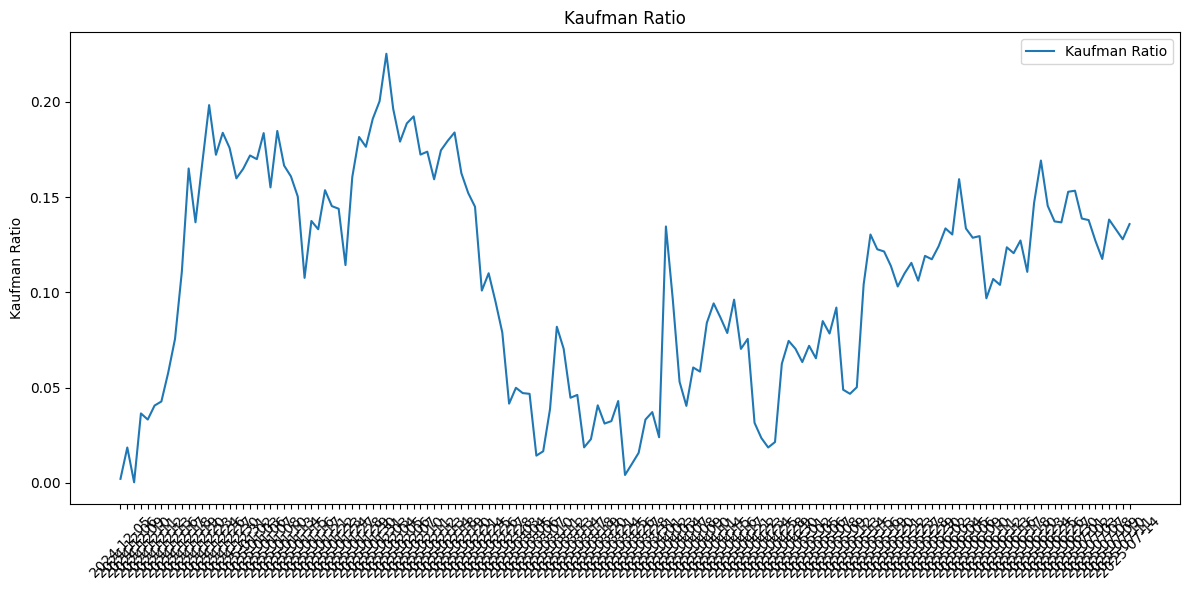

In [3]:
returns = return_df['Close'].pct_change().dropna()
return_df['Log_Return'] = np.log(return_df['Close'] / return_df['Close'].shift(1))
return_df = return_df.dropna(subset=['Log_Return'])

def kaufman_ratio(prices, window = 100):
    signal = prices.diff(window).abs()
    noise = prices.diff().abs().rolling(window).sum()

    er = signal / noise
    return er

return_df['kaufman'] = kaufman_ratio(return_df['Close'], window=100)
return_df = return_df.dropna(subset=['kaufman'])

#plot return_df['kaufman'])
plt.figure(figsize=(12, 6))
plt.plot(return_df['Date'], return_df['kaufman'], label='Kaufman Ratio')
plt.title('Kaufman Ratio')
plt.ylabel('Kaufman Ratio')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


In [4]:
return_df = return_df.dropna(subset=['kaufman'])
return_df['kaufman'].head()

101    0.002187
102    0.018630
103    0.000369
104    0.036514
105    0.033298
Name: kaufman, dtype: float64

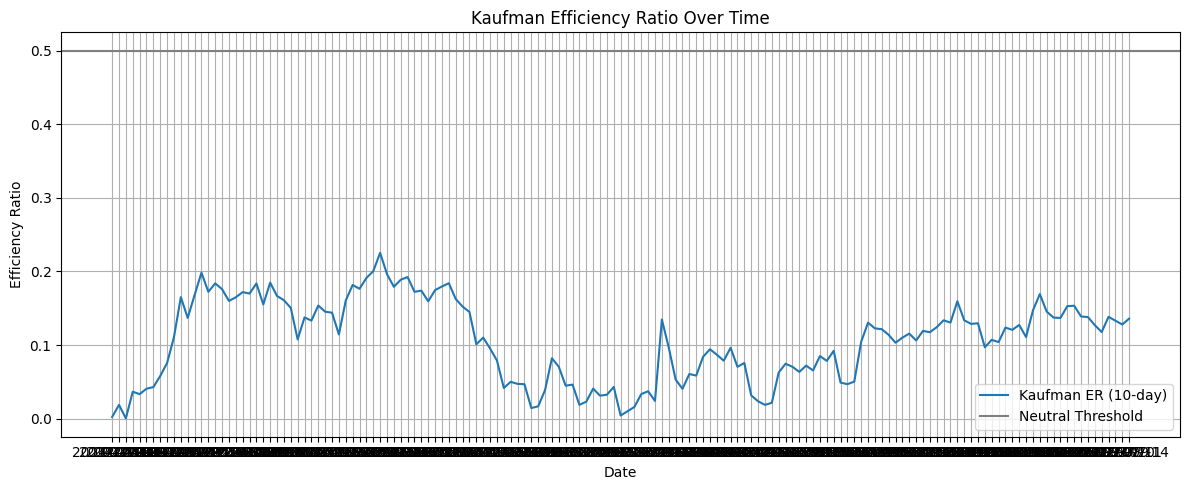

In [5]:
plt.figure(figsize=(12,5))
plt.plot(return_df['Date'], return_df['kaufman'], label='Kaufman ER (10-day)')
plt.axhline(0.5, color='gray', label='Neutral Threshold')
plt.title('Kaufman Efficiency Ratio Over Time')
plt.xlabel('Date')
plt.ylabel('Efficiency Ratio')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [6]:
series = return_df['Log_Return'].dropna() #initialise series
from statsmodels.tsa.stattools import adfuller

adf_result = adfuller(series)

print("ADF Statistic:", adf_result[0])
print("p-value:", adf_result[1])
print("Critical Values:", adf_result[4])

#hurst exponent calculation , used lag values

def hurst_exponent(ts, max_lag= 150):
    lags = range(2,max_lag)
    
    tau = [np.std(np.subtract(ts[lag:], ts[:-lag])) for lag in lags] #calculating variance Xt - Xt-lag
    
    lags = np.array(lags)  # Convert lags to a NumPy array
    tau = np.array(tau)    # Convert tau to a NumPy array
    poly = np.polyfit(np.log(lags), np.log(tau), 1)  # Apply log correctly
    return poly[0]*2.0 #log^2H

from math import log
hurst = hurst_exponent(return_df['Log_Return'].dropna().values)
print("Hurst Exponent:", hurst)

ADF Statistic: -12.21644618076069
p-value: 1.1327538136680272e-22
Critical Values: {'1%': -3.4753253063120644, '5%': -2.881274703275226, '10%': -2.5772928360116873}
Hurst Exponent: nan


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/var/folders/b1/p4nglr2j4tldllw81z_d3c4c0000gn/T/ipykernel_44240/289548075.py:19: RuntimeWarning: divide by zero encountered in log
  poly = np.polyfit(np.log(lags), np.log(tau), 1)  # Apply log correctly


In [15]:
def hurst_rs(ts, min_window=10, max_window=100):
    N = len(ts)
    H_vals = []

    for window in range(min_window, max_window):
        if window >= N:
            break
        n_chunks = N // window
        R_S = []

        for i in range(n_chunks):
            chunk = ts[i * window : (i + 1) * window]
            if len(chunk) < 2:
                continue
            mean = np.mean(chunk)
            dev = chunk - mean
            Z = np.cumsum(dev)
            R = np.max(Z) - np.min(Z)
            S = np.std(chunk, ddof=1)  # Use sample std deviation

            if S > 0 and not np.isnan(R) and not np.isnan(S):
                R_S.append(R / S)

        if len(R_S) > 0 and np.mean(R_S) > 0:
            H_vals.append((np.log(window), np.log(np.mean(R_S))))

    if len(H_vals) < 2:
        hurst_rs_value = np.nan
    else:
        log_window, log_RS = zip(*H_vals)
        slope, _ = np.polyfit(log_window, log_RS, 1)
        hurst_rs_value = slope

    log_ts = np.log(return_df['Close'].dropna().values)
    hurst = hurst_rs(log_ts)
    print("Hurst Exponent (R/S method):", hurst)
    # Get mean reversion speed
    def mean_reversion_speed(series):
        diffs = np.diff(series)
        if len(diffs) == 0:
            return np.nan
        return np.mean(diffs)
    mean_reversion = mean_reversion_speed(return_df['Log_Return'].dropna())
    print("Mean Reversion Speed:", mean_reversion)


Value at Risk (95% confidence level) using Log Returns: -0.0308


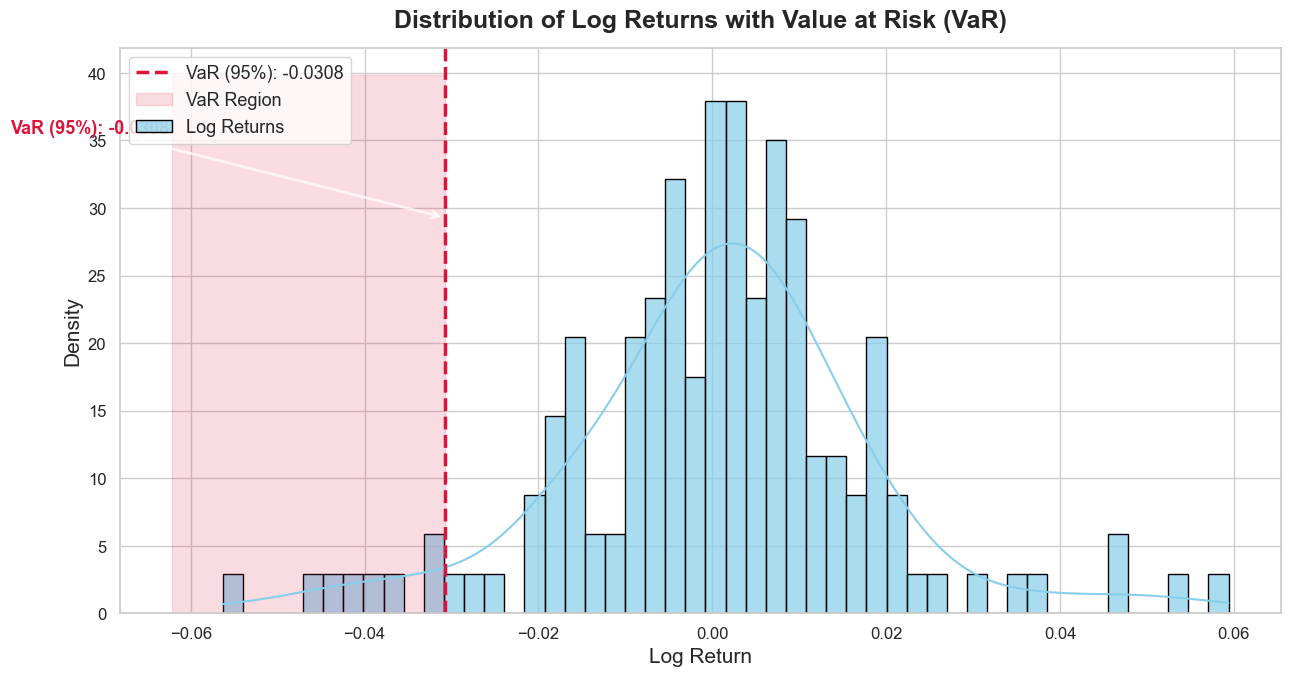

In [14]:
# Calculate log returns (ensure no NaNs in the column)
return_df['Log_Return'] = np.log(return_df['Close'] / return_df['Close'].shift(1))
log_returns = return_df['Log_Return'].dropna()

confidence_level = 0.95
VaR_95_log = np.percentile(log_returns, (1 - confidence_level) * 100)

print(f"Value at Risk (95% confidence level) using Log Returns: {VaR_95_log:.4f}")

# Improved visualization
import seaborn as sns

plt.figure(figsize=(13, 7))
sns.set(style='whitegrid', font_scale=1.2)

# Plot histogram and KDE
sns.histplot(log_returns, bins=50, kde=True, color='skyblue', edgecolor='black', stat='density', label='Log Returns', alpha=0.7)

# VaR line
plt.axvline(VaR_95_log, color='crimson', linestyle='--', linewidth=2.5, label=f'VaR (95%): {VaR_95_log:.4f}')

# Highlight area under VaR
plt.fill_betweenx(
    y=[0, plt.gca().get_ylim()[1]],
    x1=plt.gca().get_xlim()[0],
    x2=VaR_95_log,
    color='crimson',
    alpha=0.15,
    label='VaR Region'
)

# Add annotation for VaR
plt.annotate(
    f'VaR (95%): {VaR_95_log:.4f}',
    xy=(VaR_95_log, plt.gca().get_ylim()[1]*0.7),
    xytext=(VaR_95_log - 0.05, plt.gca().get_ylim()[1]*0.85),
    arrowprops=dict(facecolor='crimson', arrowstyle='->', lw=2, alpha=0.7),
    fontsize=13, color='crimson', fontweight='bold'
)

plt.title('Distribution of Log Returns with Value at Risk (VaR)', fontsize=18, fontweight='bold', pad=15)
plt.xlabel('Log Return', fontsize=15)
plt.ylabel('Density', fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=13, loc='upper left', frameon=True)
plt.tight_layout()
plt.show()

In [9]:
# get expected return percentage and probability of return assigning a holding period
def expected_return(returns, holding_period=60):
    mean_return = returns.mean()
    std_dev = returns.std()
    return mean_return * holding_period, std_dev * np.sqrt(holding_period) #expected return given holding period
def probability_of_return(returns, threshold=0.01):
    return np.mean(returns > threshold)
holding_period = 100  # 1 day
expected_return_value, expected_std_dev = expected_return(return_df['Log_Return'].dropna(), holding_period)
print(f"Expected Return: {expected_return_value:.4f}, Expected Std Dev: {expected_std_dev:.4f}")
probability = probability_of_return(return_df['Log_Return'].dropna(), threshold=0.01)
print(f"Probability of Return > 1%: {probability:.4f}")



Expected Return: 0.0564, Expected Std Dev: 0.1760
Probability of Return > 1%: 0.2230


/var/folders/b1/p4nglr2j4tldllw81z_d3c4c0000gn/T/ipykernel_44240/2130910643.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


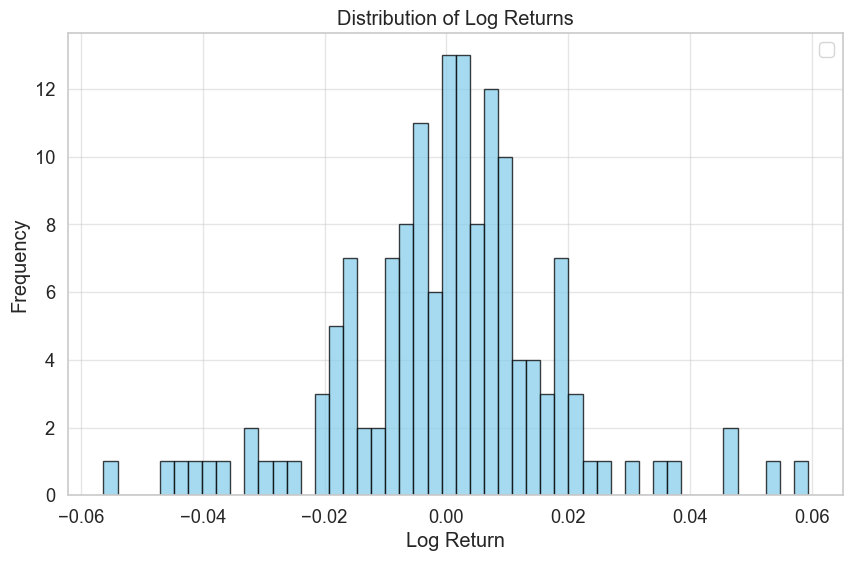

In [17]:
plt.figure(figsize=(10, 6))
plt.hist(return_df['Log_Return'].dropna(), bins=50, alpha=0.75, color='skyblue', edgecolor='black')
plt.title('Distribution of Log Returns')
plt.xlabel('Log Return')
plt.ylabel('Frequency')
plt.legend()
plt.grid(alpha=0.5)
plt.show()

In [18]:
# win rate probability
def win_rate(returns):
    return np.mean(returns > returns.mean())
win_rate_value = win_rate(return_df['Log_Return'].dropna())
print(f"Win Rate: {win_rate_value:.4f}")

Win Rate: 0.5473
